# Preparation of ALK Binding to Inhibitors
---

### Step 1: Download Ligand Structures from PubChem
In this step, we’ll download the structures the inhibitors from PubChem in SDF format. Each structure will be saved locally in a designated folder called `ligands`.

In [1]:
import requests  # For HTTP requests
import os  # For directory operations

# Define a dictionary of drug names and their PubChem CIDs
ligands = {
    "Crizotinib": 11626560,
    "Ceritinib": 57379345,
    "Alectinib": 49806720,
    "Brigatinib": 68165256,
    "Ensartinib": 56960363,
    "Lorlatinib": 71731823
}

# Create a directory to store downloaded SDF files
os.makedirs("ligands", exist_ok=True)

# Function to download SDF file from PubChem
def download_sdf(drug_name: str, cid: int) -> None:
    try:
        sdf_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/SDF"
        response = requests.get(sdf_url)
        if response.status_code == 200:
            with open(f"ligands/{drug_name.lower()}.sdf", "wb") as file:
                file.write(response.content)
            print(f"{drug_name} saved as ligands/{drug_name.lower()}.sdf")
        else:
            print(f"Failed to download {drug_name}: HTTP {response.status_code}")
    except Exception as e:
        print(f"Error downloading {drug_name}: {str(e)}")

# Function to query BindingDB for Ki values using PubChem CID
def query_bindingdb_ki(cid: int) -> None:
    try:
        url = f"https://www.bindingdb.org/bind/chemsearch/BindingDBPubChemTarget.jsp?cid={cid}"
        response = requests.get(url)
        if response.status_code == 200 and "Ki" in response.text:
            print(f"Potential Ki data available for CID {cid} — Check manually: {url}")
        else:
            print(f"No Ki data found or page inaccessible for CID {cid}")
    except Exception as e:
        print(f"Error querying BindingDB for CID {cid}: {str(e)}")

# Loop through ligands to download SDFs and query Ki values
for drug_name, cid in ligands.items():
    download_sdf(drug_name, cid)
    query_bindingdb_ki(cid)


Crizotinib saved as ligands/crizotinib.sdf
No Ki data found or page inaccessible for CID 11626560
Ceritinib saved as ligands/ceritinib.sdf
No Ki data found or page inaccessible for CID 57379345
Alectinib saved as ligands/alectinib.sdf
No Ki data found or page inaccessible for CID 49806720
Brigatinib saved as ligands/brigatinib.sdf
No Ki data found or page inaccessible for CID 68165256
Ensartinib saved as ligands/ensartinib.sdf
No Ki data found or page inaccessible for CID 56960363
Lorlatinib saved as ligands/lorlatinib.sdf
No Ki data found or page inaccessible for CID 71731823


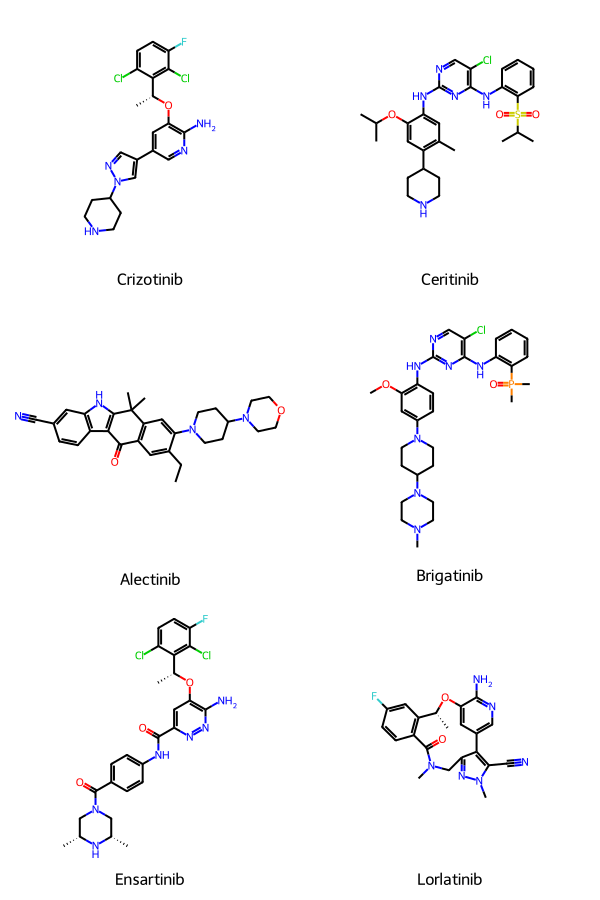

In [2]:
# Import necessary libraries from RDKit
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display  # For displaying images in Jupyter Notebook
import os  # To check file existence

# Function to visualize 2D structures of ligands from SDF files
def visualize_ligands_2D(ligands: dict) -> None:
    """
    Generates and displays 2D structures of ligands from SDF files.

    Args:
        ligands (dict): Dictionary mapping ligand names to their SDF file paths.
    """
    # List to hold RDKit Mol objects
    mols = []
    legends = []

    # Iterate through ligands and attempt to load each
    for ligand_name, file_path in ligands.items():
        try:
            # Ensure the file exists
            if not os.path.exists(file_path):
                print(f"File not found for {ligand_name}: {file_path}")
                continue

            # Load the molecule from the file
            mol = Chem.MolFromMolFile(file_path)
            if mol is None:
                print(f"RDKit failed to parse {ligand_name}: {file_path}")
                continue

            # Annotate the molecule with its name
            mol.SetProp("_Name", ligand_name)
            mols.append(mol)
            legends.append(ligand_name)

        except Exception as e:
            print(f"Error processing {ligand_name}: {str(e)}")

    # Draw all valid molecules in a grid
    if mols:
        img = Draw.MolsToGridImage(
            mols,
            molsPerRow=2,
            subImgSize=(300, 300),
            legends=legends
        )
        display(img)
    else:
        print("No valid molecules found to display.")

# Example usage with updated paths
ligands_sdf_paths = {
    "Crizotinib": "ligands/crizotinib.sdf",
    "Ceritinib": "ligands/ceritinib.sdf",
    "Alectinib": "ligands/alectinib.sdf",
    "Brigatinib": "ligands/brigatinib.sdf",
    "Ensartinib": "ligands/ensartinib.sdf",
    "Lorlatinib": "ligands/lorlatinib.sdf"
}

# Visualize the ligands
visualize_ligands_2D(ligands_sdf_paths)


### Step 2: Optimize Ligand Structures
Using RDKit, we’ll load the SDF files, add hydrogens to each molecule, and optimize their 3D structures. The optimized structures will be saved in PDB format.

In [3]:
from rdkit import Chem  # RDKit Chem module for molecule handling
from rdkit.Chem import AllChem  # AllChem for 3D coordinate generation and optimization
import os  # OS module for path management

# Define ligand names and corresponding SDF file paths
ligands: dict[str, str] = {
    "Crizotinib": "ligands/crizotinib.sdf",
    "Ceritinib": "ligands/ceritinib.sdf",
    "Alectinib": "ligands/alectinib.sdf",
    "Brigatinib": "ligands/brigatinib.sdf",
    "Ensartinib": "ligands/ensartinib.sdf",
    "Lorlatinib": "ligands/lorlatinib.sdf"
}

# Process each ligand for 3D embedding and optimization
for ligand_name, sdf_path in ligands.items():
    try:
        # Ensure the SDF file exists
        if not os.path.exists(sdf_path):
            print(f"File not found: {sdf_path}")
            continue

        # Load the molecule from the file with hydrogens preserved
        mol: Chem.Mol | None = Chem.MolFromMolFile(sdf_path, removeHs=False)
        if mol is None:
            print(f"RDKit failed to parse molecule for {ligand_name} from {sdf_path}")
            continue

        # Add explicit hydrogens
        mol = Chem.AddHs(mol)

        # Embed the molecule in 3D with fixed seed
        if AllChem.EmbedMolecule(mol, randomSeed=0xf00d) != 0:
            print(f"3D embedding failed for {ligand_name}")
            continue

        # Attempt MMFF94 optimization first
        if AllChem.MMFFHasAllMoleculeParams(mol):
            result = AllChem.MMFFOptimizeMolecule(mol, maxIters=1000)
            if result != 0:
                print(f"MMFF94 optimization may not have converged for {ligand_name}")
        else:
            # Fallback to UFF if MMFF not applicable
            result = AllChem.UFFOptimizeMolecule(mol, maxIters=2000)
            if result != 0:
                print(f"UFF optimization may not have converged for {ligand_name}")

        # Save the optimized structure to PDB
        pdb_path = f"ligands/{ligand_name.lower()}_optimized.pdb"
        Chem.MolToPDBFile(mol, pdb_path)
        print(f"Ligand {ligand_name} optimized and saved to {pdb_path}")

    except Exception as e:
        print(f"An error occurred while processing {ligand_name}: {e}")


Ligand Crizotinib optimized and saved to ligands/crizotinib_optimized.pdb
Ligand Ceritinib optimized and saved to ligands/ceritinib_optimized.pdb
Ligand Alectinib optimized and saved to ligands/alectinib_optimized.pdb
Ligand Brigatinib optimized and saved to ligands/brigatinib_optimized.pdb
Ligand Ensartinib optimized and saved to ligands/ensartinib_optimized.pdb
Ligand Lorlatinib optimized and saved to ligands/lorlatinib_optimized.pdb


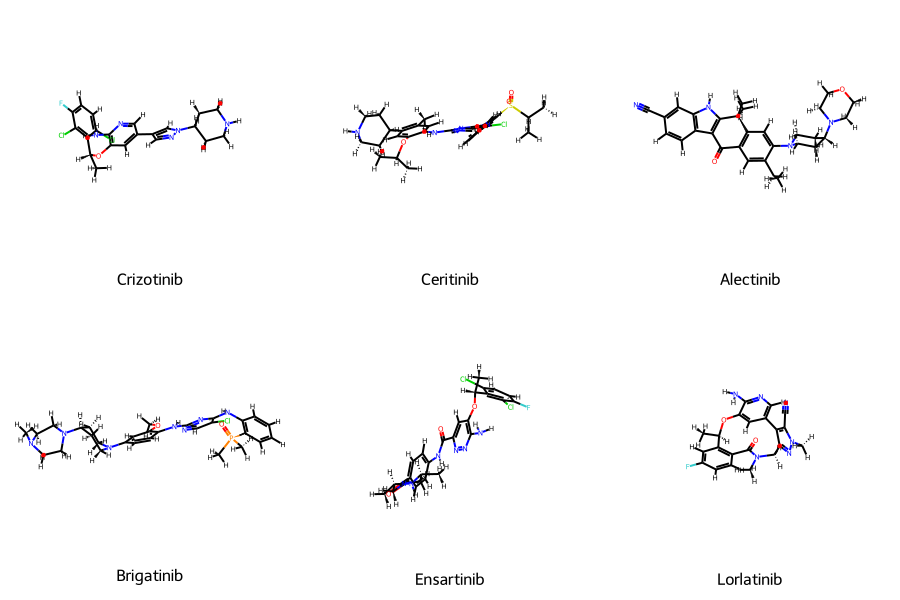

In [4]:
from rdkit import Chem
from rdkit.Chem import Draw
import os
from IPython.display import display  # Needed to display images in notebooks

# Define the paths to optimized ligands
ligands = {
    "Crizotinib": "ligands/crizotinib_optimized.pdb",
    "Ceritinib": "ligands/ceritinib_optimized.pdb",
    "Alectinib": "ligands/alectinib_optimized.pdb",
    "Brigatinib": "ligands/brigatinib_optimized.pdb",
    "Ensartinib": "ligands/ensartinib_optimized.pdb",
    "Lorlatinib": "ligands/lorlatinib_optimized.pdb"
}

# Load molecules
mol_list = []
legends = []

for name, path in ligands.items():
    if os.path.exists(path):
        mol = Chem.MolFromPDBFile(path, removeHs=False)
        if mol:
            mol.SetProp("_Name", name)
            mol_list.append(mol)
            legends.append(name)

# Generate the 2D grid image
img = Draw.MolsToGridImage(mol_list, molsPerRow=3, subImgSize=(300, 300), legends=legends)

# Display the image
display(img)


### Step 3: Visualizing and Preparing the Protein Structure

In this step, we will load the protein structure file and prepare it for docking. We’ll use the MDAnalysis and NGLView libraries to visualize and selectively isolate parts of the structure that are essential for docking.

This part of the process includes:

1. **Loading the Protein Structure**: We’ll load the PDB file using MDAnalysis, which allows us to manipulate and visualize molecular structures. MDAnalysis creates a "universe" for our molecular system that we can work with.

2. **Isolating Relevant Components**:
   - **Protein**: We’ll isolate the protein itself by selecting only residues marked as part of the protein.
   - **Primary Ligand**: Already bound to protein is our primary ligand of interest, which will be isolated and saved separately for visualization.
   - **Other Molecules**: These extraneous molecules will not be included in further preparation steps as they are not needed for our docking calculations.

3. **Visualizing the Structure**: Using NGLView, we will set up a visual representation of the structure to better understand the positioning of the ligand relative to the protein.

4. **Saving Cleaned Structures**: Finally, we save separate files for the protein and ligand, which will be used in the next steps to ensure the structure is in the optimal state for docking calculations.

By completing this step, we prepare the structure so that it contains only the components essential for docking, with all extraneous molecules removed. This helps to prevent errors in subsequent steps and ensures the protein is in the correct condition for further processing. 


#### Step 3.1: Downloading the Protein Structure from RCSB PDB

The first task in preparing the protein for docking is to download its structure from the Protein Data Bank (PDB). We’ll save this structure in our project directory for further processing.


In [5]:
import os
import requests  # For downloading PDB files

# List of PDB IDs with corresponding drug names and ligands
structures = {
    "4CLI": "Lorlatinib",    # Ligand 5P8
    "2XP2": "Crizotinib",    # Ligand VGH
    "4MKC": "Ceritinib",     # Ligand 4MK
    "5FTO": "Entrectinib"    # Ligand YMX
}

# Directory to save downloaded PDB files
protein_directory = "protein_structures"
os.makedirs(protein_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Loop through and download each PDB file
for pdb_id, drug_name in structures.items():
    try:
        print(f"Downloading {drug_name} structure ({pdb_id})...")
        response = requests.get(f"https://files.rcsb.org/download/{pdb_id}.pdb")
        if response.status_code == 200:
            filepath = os.path.join(protein_directory, f"{pdb_id}.pdb")
            with open(filepath, "w") as f:
                f.write(response.text)
            print(f"Saved to {filepath}")
        else:
            print(f"Failed to download {pdb_id}. Status code: {response.status_code}")
    except Exception as e:
        print(f"Error downloading {pdb_id}: {e}")


Saved to protein_structures/4CLI.pdb
Saved to protein_structures/2XP2.pdb
Saved to protein_structures/4MKC.pdb
Saved to protein_structures/5FTO.pdb


In [6]:
import os
import numpy as np

# Define the PDB IDs and corresponding ligand residue names
ligand_info = {
    "4CLI": "5P8",  # Lorlatinib
    "2XP2": "VGH",  # Crizotinib
    "4MKC": "4MK",  # Ceritinib
    "5FTO": "YMX"   # Entrectinib
}

# Directory containing your downloaded PDB files
protein_directory = "protein_structures"

# Function to calculate the centroid of a ligand
def calculate_ligand_centroid(pdb_file: str, ligand_resname: str) -> np.ndarray:
    coords = []
    with open(pdb_file, "r") as f:
        for line in f:
            if line.startswith("HETATM") and ligand_resname in line[17:20]:
                x = float(line[30:38])
                y = float(line[38:46])
                z = float(line[46:54])
                coords.append([x, y, z])
    coords = np.array(coords)
    if coords.shape[0] == 0:
        raise ValueError(f"No atoms found for ligand {ligand_resname} in {pdb_file}")
    return coords.mean(axis=0)

# Compute and print centroids
for pdb_id, ligand in ligand_info.items():
    try:
        path = os.path.join(protein_directory, f"{pdb_id}.pdb")
        centroid = calculate_ligand_centroid(path, ligand)
        print(f"{pdb_id} ({ligand}) Centroid: {centroid}")
    except Exception as e:
        print(f"Error processing {pdb_id}: {e}")


4CLI (5P8) Centroid: [30.7953     46.20653333  8.3475    ]
2XP2 (VGH) Centroid: [29.9232     47.06613333  8.53853333]
4MKC (4MK) Centroid: [-21.253        9.83992105  -7.66826316]
5FTO (YMX) Centroid: [ 4.43878049 19.53419512  7.56668293]


In [7]:
from Bio.PDB import PDBParser, Superimposer, is_aa
import numpy as np

# Function to extract CA atoms from a structure
def extract_ca_atoms(structure):
    ca_atoms = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if is_aa(residue, standard=True):
                    if 'CA' in residue:
                        ca_atoms.append(residue['CA'])
    return ca_atoms

# Function to extract ligand coordinates by residue name
def extract_ligand_coords(structure, ligand_resname):
    ligand_coords = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.get_resname() == ligand_resname:
                    for atom in residue:
                        ligand_coords.append(atom.coord)
    return np.array(ligand_coords)

# PDB IDs and ligand names
structures = {
    "4CLI": "5P8",
    "2XP2": "VGH",
    "4MKC": "4MK",
    "5FTO": "YMX"
}

ref_id = "4CLI"
ref_file = f"protein_structures/{ref_id}.pdb"
parser = PDBParser(QUIET=True)
ref_structure = parser.get_structure(ref_id, ref_file)
ref_atoms = extract_ca_atoms(ref_structure)

# Superimpose and compute ligand centroids
for pdb_id, ligand_name in structures.items():
    mobile_file = f"protein_structures/{pdb_id}.pdb"
    mobile_structure = parser.get_structure(pdb_id, mobile_file)
    mobile_atoms = extract_ca_atoms(mobile_structure)

    # Align to reference
    super_imposer = Superimposer()
    super_imposer.set_atoms(ref_atoms[:len(mobile_atoms)], mobile_atoms[:len(ref_atoms)])
    super_imposer.apply(mobile_structure.get_atoms())

    # Get ligand coordinates and centroid
    ligand_coords = extract_ligand_coords(mobile_structure, ligand_name)
    if ligand_coords.size > 0:
        centroid = np.mean(ligand_coords, axis=0)
        print(f"{pdb_id} ({ligand_name}) Centroid: {centroid}")
    else:
        print(f"{pdb_id}: Ligand {ligand_name} not found.")


4CLI (5P8) Centroid: [30.7953   46.206524  8.347501]
2XP2 (VGH) Centroid: [29.068743 46.486355  9.375442]
4MKC (4MK) Centroid: [31.86367   48.085682   6.5858808]
5FTO (YMX) Centroid: [31.266443  48.42774    7.2754703]


##### Step 3.1.1: Visualizing the Protein Structure with Py3Dmol

To get an initial look at the full protein structure, we’ll use **py3Dmol** for 3D visualization. This will allow us to view the entire protein and verify that the download was successful. Py3Dmol provides an interactive environment where we can easily rotate and zoom into the structure.

In this visualization:
- **Protein**: Displayed in a spectrum color scheme to differentiate the protein regions.
- **3D Viewer**: Allows zooming, rotation, and interaction to closely inspect the structure.


In [8]:
# Import py3Dmol for protein visualization
import py3Dmol

# Define the path to the downloaded PDB file
protein_pdb_path = f"{protein_directory}/{pdb_id}.pdb"

# Load and display the protein structure using py3Dmol
with open(protein_pdb_path, "r") as file:
    pdb_content = file.read()  # Read the PDB file content

# Initialize the viewer
view = py3Dmol.view(width=800, height=600)
view.addModel(pdb_content, "pdb")  # Load the PDB content into the viewer
view.setStyle({"cartoon": {"color": "spectrum"}})  # Display style for protein
view.zoomTo()  # Adjust view to focus on the entire protein
view.show()  # Display the viewer

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

#### Step 3.2: Visualizing the Protein Structure

With the protein file downloaded, we’ll now load it into MDAnalysis and use NGLView for visualization. This will allow us to examine the structure and verify the presence of the primary ligand (FAJ) and any extraneous molecules, such as GOL and CL.


In [9]:
# === Step 1: Imports ===
import os
import MDAnalysis as mda
import nglview as nv

# === Step 2: Define structure set ===
structures = {
    "4CLI": "5P8",   # Lorlatinib
    "2XP2": "VGH",   # Crizotinib
    "4MKC": "4MK",   # Ceritinib
    "5FTO": "YMX"    # Entrectinib
}

# === Step 3: File paths ===
protein_dir = "protein_structures"
ligand_dir = "ligands"
os.makedirs(ligand_dir, exist_ok=True)

# === Step 4: Loop through each PDB structure ===
for pdb_id, ligand_resname in structures.items():
    print(f"\nProcessing {pdb_id} with ligand {ligand_resname}...")

    # Load the PDB structure
    pdb_path = f"{protein_dir}/{pdb_id}.pdb"
    u = mda.Universe(pdb_path)

    # Select relevant atom groups
    protein = u.select_atoms("protein")
    ligand = u.select_atoms(f"resname {ligand_resname}")
    water = u.select_atoms("resname HOH")

    # Print selection summary
    print(f"Protein atoms: {len(protein)}")
    print(f"Ligand atoms ({ligand_resname}): {len(ligand)}")
    print(f"Water molecules: {len(water)}")

    # Save extracted structures
    protein_output = f"{protein_dir}/protein_{pdb_id}.pdb"
    ligand_output = f"{ligand_dir}/{ligand_resname.lower()}.pdb"
    protein.write(protein_output)
    ligand.write(ligand_output)
    print(f"Saved protein to {protein_output}")
    print(f"Saved ligand to {ligand_output}")

    # === Step 5: Visualize in nglview ===
    view = nv.show_mdanalysis(protein)
    view.clear_representations()
    view.add_representation("cartoon", color="spectrum")
    view.add_representation("surface", color="white", opacity=0.3)

    ligand_component = view.add_component(ligand)
    ligand_component.clear_representations()
    ligand_component.add_representation("ball+stick", color="element")

    view.center()
    display(view)  # Comment this line if not running in Jupyter



Processing 4CLI with ligand 5P8...
Protein atoms: 2314
Ligand atoms (5P8): 30
Water molecules: 232
Saved protein to protein_structures/protein_4CLI.pdb
Saved ligand to ligands/5p8.pdb


NGLWidget()


Processing 2XP2 with ligand VGH...
Protein atoms: 2262
Ligand atoms (VGH): 30
Water molecules: 167
Saved protein to protein_structures/protein_2XP2.pdb
Saved ligand to ligands/vgh.pdb


/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


NGLWidget()


Processing 4MKC with ligand 4MK...
Protein atoms: 2406
Ligand atoms (4MK): 38
Water molecules: 175
Saved protein to protein_structures/protein_4MKC.pdb
Saved ligand to ligands/4mk.pdb


/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


NGLWidget()


Processing 5FTO with ligand YMX...
Protein atoms: 2344
Ligand atoms (YMX): 41
Water molecules: 182
Saved protein to protein_structures/protein_5FTO.pdb
Saved ligand to ligands/ymx.pdb


/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


NGLWidget()

### Step 4: Cleaning and Preparing the Protein Structure

In this step, we’ll perform essential cleaning and preparation of the protein structure to ensure it’s in an optimal state for docking. To avoid issues encountered previously (like unsupported tags), we’ll use a combination of tools to create a final structure with only the necessary atoms and adjustments for compatibility with AutoDock Vina.

#### Overview of Cleaning and Preparation

Our goal is to create a fully cleaned and ready structure for docking by removing extraneous molecules, adjusting protonation states, and setting partial charges. Here’s a summary of what each tool will accomplish:

1. **PDBFixer**: Removes heteroatoms (such as water molecules or extraneous ligands) and adds any missing atoms and hydrogens to complete the protein structure.
2. **PDB2PQR**: Adjusts the protonation state of the protein to a neutral pH and adds partial charges. This step is crucial for accurate modeling of interactions during docking.
3. **Open Babel**: Converts the final structure to PDBQT format and ensures that all tags are compatible with AutoDock Vina, removing any unsupported tags (like "branch") that could interfere with docking.

By using this sequence, we ensure the protein structure is standardized, fully charged, and free from non-standard elements.

---

#### Step 4.1: Initial Cleaning with PDBFixer

The first step is to use **PDBFixer** to prepare the basic structure of the protein. PDBFixer is useful for resolving missing atoms, adding hydrogens, and removing unnecessary molecules. Here’s what we’ll accomplish:

- **Load the Protein Structure**: Start by loading the PDB file with PDBFixer.
- **Remove Extraneous Molecules**: Remove non-essential molecules, such as water and ions, but retain the main ligand.
- **Add Missing Atoms**: Complete the protein structure by adding any missing residues, atoms, or hydrogens at a neutral pH.

In [10]:
import os
import time
import subprocess
import pdbfixer
from openmm.app import PDBFile

# === Constants ===
protein_directory = "protein_structures"
pdbqt_directory = "pdbqt"
os.makedirs(pdbqt_directory, exist_ok=True)

# All ALK inhibitors with their ligand IDs
structures = {
    "4CLI": "5P8",
    "2XP2": "VGH",
    "4MKC": "4MK",
    "5FTO": "YMX"
}

# === Step 1: Clean Protein Structures with PDBFixer ===
for pdb_id in structures:
    protein_path = os.path.join(protein_directory, f"protein_{pdb_id}.pdb")
    base_name, ext = os.path.splitext(protein_path)
    cleaned_protein_path = f"{base_name}_cleaned{ext}"

    if os.path.exists(cleaned_protein_path):
        print(f"[✓] {cleaned_protein_path} already exists. Skipping cleaning.")
        continue

    print(f"\n[→] Cleaning {pdb_id}...")

    try:
        start = time.time()
        fixer = pdbfixer.PDBFixer(filename=protein_path)
        fixer.removeHeterogens(keepWater=False)
        fixer.findMissingResidues()
        fixer.findMissingAtoms()
        fixer.addMissingAtoms()
        fixer.addMissingHydrogens(pH=7.4)

        with open(cleaned_protein_path, 'w') as out_file:
            PDBFile.writeFile(fixer.topology, fixer.positions, out_file)

        print(f"[✓] Cleaned protein saved to {cleaned_protein_path} ({time.time() - start:.2f} sec)")
    except Exception as e:
        print(f"[✗] Cleaning failed for {pdb_id}: {e}")

# === Step 2: Convert to PQR with PDB2PQR ===
def run_pdb2pqr(input_path: str, output_path: str, pH: float = 7.4) -> None:
    try:
        subprocess.run([
            "pdb2pqr", "--ff=AMBER", f"--with-ph={pH}", input_path, output_path
        ], check=True, capture_output=True, text=True)
        print(f"[✓] PQR created: {output_path}")
    except subprocess.CalledProcessError as e:
        print(f"[✗] PDB2PQR failed for {input_path}")
        print("STDERR:", e.stderr)
    except FileNotFoundError:
        print("[✗] PDB2PQR not found. Is it installed?")

for pdb_id in structures:
    cleaned_path = os.path.join(protein_directory, f"protein_{pdb_id}_cleaned.pdb")
    pqr_output = cleaned_path.replace(".pdb", ".pqr")

    if os.path.exists(pqr_output):
        print(f"[✓] {pqr_output} already exists. Skipping PDB2PQR.")
        continue

    print(f"\n[→] Running PDB2PQR on {pdb_id}...")
    run_pdb2pqr(cleaned_path, pqr_output)

# === Step 3: Convert to PDBQT with Open Babel ===
for pdb_id in structures:
    pqr_path = os.path.join(protein_directory, f"protein_{pdb_id}_cleaned.pqr")
    pdbqt_path = os.path.join(pdbqt_directory, f"protein_{pdb_id}.pdbqt")

    if os.path.exists(pdbqt_path):
        print(f"[✓] {pdbqt_path} already exists. Skipping Open Babel.")
        continue

    print(f"\n[→] Converting {pqr_path} to PDBQT...")
    try:
        start = time.time()
        with open(os.devnull, 'w') as devnull:
            subprocess.run(
                ["obabel", pqr_path, "-O", pdbqt_path, "--partialcharge"],
                check=True, stdout=devnull, stderr=devnull
            )
        print(f"[✓] Converted to {pdbqt_path} ({time.time() - start:.2f} sec)")
    except FileNotFoundError:
        print("[✗] Open Babel (obabel) not found. Please install it.")
    except subprocess.CalledProcessError as e:
        print(f"[✗] Open Babel failed for {pqr_path}. Exit code: {e.returncode}")


[✓] protein_structures/protein_4CLI_cleaned.pdb already exists. Skipping cleaning.
[✓] protein_structures/protein_2XP2_cleaned.pdb already exists. Skipping cleaning.
[✓] protein_structures/protein_4MKC_cleaned.pdb already exists. Skipping cleaning.
[✓] protein_structures/protein_5FTO_cleaned.pdb already exists. Skipping cleaning.
[✓] protein_structures/protein_4CLI_cleaned.pqr already exists. Skipping PDB2PQR.
[✓] protein_structures/protein_2XP2_cleaned.pqr already exists. Skipping PDB2PQR.
[✓] protein_structures/protein_4MKC_cleaned.pqr already exists. Skipping PDB2PQR.
[✓] protein_structures/protein_5FTO_cleaned.pqr already exists. Skipping PDB2PQR.
[✓] pdbqt/protein_4CLI.pdbqt already exists. Skipping Open Babel.
[✓] pdbqt/protein_2XP2.pdbqt already exists. Skipping Open Babel.
[✓] pdbqt/protein_4MKC.pdbqt already exists. Skipping Open Babel.
[✓] pdbqt/protein_5FTO.pdbqt already exists. Skipping Open Babel.


In [11]:
import pdbfixer
from openmm.app import PDBFile
import os
import time

# Define constants
protein_directory = "protein_structures"
pdb_id = "5FTO"  # Example PDB ID, can be replaced dynamically
protein_path = os.path.join(protein_directory, f"protein_{pdb_id}.pdb")
base_name, ext = os.path.splitext(protein_path)
cleaned_protein_path = f"{base_name}_cleaned{ext}"

# Skip if already cleaned
if os.path.exists(cleaned_protein_path):
    print(f"{cleaned_protein_path} already exists. Skipping cleaning step.")
else:
    print("Starting protein cleaning process...")
    start_time = time.time()

    try:
        # Load the original protein structure
        fixer = pdbfixer.PDBFixer(filename=protein_path)
        print("Loaded isolated protein structure.")

        # Remove heterogens (non-protein ligands, ions, waters)
        fixer.removeHeterogens(keepWater=False)
        print("Removed heterogens (non-protein residues and waters).")

        # Identify and fill in missing components
        fixer.findMissingResidues()
        fixer.findMissingAtoms()
        fixer.addMissingAtoms()
        print("Identified and added missing residues/atoms.")

        # Add hydrogens at physiological pH
        fixer.addMissingHydrogens(pH=7.4)
        print("Added missing hydrogens (pH 7.4).")

        # Save cleaned protein to new file
        with open(cleaned_protein_path, 'w') as out_file:
            PDBFile.writeFile(fixer.topology, fixer.positions, out_file)
        print(f"Cleaned protein saved to {cleaned_protein_path}")

        duration = time.time() - start_time
        print(f"Cleaning completed in {duration:.2f} seconds.")
    
    except Exception as e:
        print(f"Protein cleaning failed: {e}")


protein_structures/protein_5FTO_cleaned.pdb already exists. Skipping cleaning step.


### Step 4.2: Adjusting Protonation and Charges with PDB2PQR

After initial cleaning, we’ll use **PDB2PQR** to set the protonation state of the protein and add partial charges. PDB2PQR is tailored for handling biomolecular structures, particularly for docking and simulation studies. Here’s what this step entails:

- **Protonation State**: Set the protein to a neutral pH to represent physiological conditions.
- **Partial Charges**: Add partial charges to the atoms, which will be crucial for accurately modeling binding interactions.


In [12]:
import subprocess
import os

# Constants
protein_directory = "protein_structures"
pdb_id = "5FTO"
protein_cleaned_path = os.path.join(protein_directory, f"protein_{pdb_id}_cleaned.pdb")
pqr_output_path = protein_cleaned_path.replace(".pdb", ".pqr")

def run_pdb2pqr(input_path: str, output_path: str, pH: float = 7.4) -> None:
    """
    Runs the PDB2PQR tool to convert a cleaned PDB file into a PQR file,
    which includes charge and protonation state information appropriate for a given pH.

    Args:
        input_path (str): Path to the input PDB file.
        output_path (str): Path where the resulting PQR file will be saved.
        pH (float): The pH at which to adjust protonation states. Default is 7.4.
    """
    try:
        command = [
            "pdb2pqr",
            "--ff=AMBER",
            f"--with-ph={pH}",
            input_path,
            output_path
        ]
        result = subprocess.run(command, capture_output=True, text=True, check=True)
        print(f"Successfully converted to PQR: {output_path}")

    except subprocess.CalledProcessError as e:
        print(f"PDB2PQR failed with exit code {e.returncode}")
        print("STDOUT:", e.stdout)
        print("STDERR:", e.stderr)

    except FileNotFoundError:
        print("PDB2PQR is not installed or not found in the system path.")

# Only run PDB2PQR if the output file does not already exist
if not os.path.exists(pqr_output_path):
    print("Starting PDB2PQR conversion...")
    run_pdb2pqr(protein_cleaned_path, pqr_output_path)
else:
    print(f"PQR file already exists at {pqr_output_path}")


PQR file already exists at protein_structures/protein_5FTO_cleaned.pqr


#### Step 4.3: Converting to PDBQT Format with Open Babel

The final step in the cleaning process is to use **Open Babel** to convert the structure to **PDBQT** format. This format is required by AutoDock Vina and ensures that any unsupported tags (such as "branch") are removed. Open Babel provides compatibility and standardization across various chemical formats, making it an ideal tool for final preparations.

- **Convert to PDBQT**: Convert the PQR file to PDBQT, adding partial charges as needed for docking compatibility.
- **Verify Compatibility**: Open Babel will remove any unsupported tags and finalize the file in the required format.


In [13]:
import os
import subprocess
import time

# Constants for input and output paths
protein_directory = "protein_structures"
pdb_id = "5FTO"
pqr_path = f"{protein_directory}/protein_{pdb_id}_cleaned.pqr"

# Create output directory if needed
pdbqt_directory = "pdbqt"
os.makedirs(pdbqt_directory, exist_ok=True)

# Construct the output PDBQT path
pdbqt_output_path = os.path.join(pdbqt_directory, os.path.basename(pqr_path).replace(".pqr", ".pdbqt"))

# Skip if the PDBQT already exists
if os.path.exists(pdbqt_output_path):
    print(f"{pdbqt_output_path} already exists. Skipping conversion.")
else:
    print("Starting PQR to PDBQT conversion using Open Babel...")

    try:
        start_time = time.time()

        # Run Open Babel for conversion and suppress verbose output
        with open(os.devnull, 'w') as devnull:
            subprocess.run(
                ["obabel", pqr_path, "-O", pdbqt_output_path, "--partialcharge"],
                check=True,
                stdout=devnull,
                stderr=devnull
            )

        duration = time.time() - start_time
        print(f"Successfully converted to {pdbqt_output_path} in {duration:.2f} seconds.")

    except FileNotFoundError:
        print("Open Babel (obabel) is not installed or not found in the system path.")
    except subprocess.CalledProcessError as e:
        print(f"Open Babel failed to convert {pqr_path} to PDBQT. Exit code: {e.returncode}")

print("PQR to PDBQT conversion step complete.")


pdbqt/protein_5FTO_cleaned.pdbqt already exists. Skipping conversion.
PQR to PDBQT conversion step complete.


In [14]:
import os
import numpy as np
import py3Dmol
from MDAnalysis import Universe

def visualize_gridbox(pdb_id: str, resname: str, box_size: float = 20.0):
    """
    Visualizes the protein, ligand, and docking grid box in py3Dmol.
    """
    protein_directory = "protein_structures"
    pdb_path = os.path.join(protein_directory, f"{pdb_id}.pdb")

    # Load PDB and extract ligand centroid
    u = Universe(pdb_path)
    ligand = u.select_atoms(f"resname {resname}")
    
    if len(ligand) == 0:
        print(f"Error: Ligand {resname} not found in {pdb_id}")
        return

    centroid = ligand.positions.mean(axis=0)
    half_box = box_size / 2

    # Prepare py3Dmol viewer
    with open(pdb_path, "r") as f:
        pdb_data = f.read()

    viewer = py3Dmol.view(width=800, height=600)
    viewer.addModel(pdb_data, "pdb")
    viewer.setStyle({"cartoon": {"color": "spectrum"}})

    # Add ligand with different representation
    viewer.addStyle({"resn": resname}, {"stick": {"radius": 0.25}, "sphere": {"scale": 0.3}})

    # Draw wireframe cube for grid box
    viewer.addBox({
        "center": {
            "x": float(centroid[0]),
            "y": float(centroid[1]),
            "z": float(centroid[2])
        },
        "dimensions": {
            "w": box_size,
            "h": box_size,
            "d": box_size
        },
        "color": "red",
        "opacity": 0.4,
        "linewidth": 1
    })

    viewer.zoomTo()
    return viewer.show()

# Example usage: change the PDB ID and ligand as needed
visualize_gridbox("4CLI", "5P8", box_size=20.0)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [15]:
import os
import numpy as np
from Bio.PDB import PDBParser

# Define the PDB IDs and their corresponding ligand residue names
structures = {
    "4CLI": "5P8",
    "2XP2": "VGH",
    "4MKC": "4MK",
    "5FTO": "YMX"
}

# Initialize parser
parser = PDBParser(QUIET=True)
ca_dir = "ca_coords"
os.makedirs(ca_dir, exist_ok=True)

# Loop through all structures
for pdb_id in structures:
    pdb_path = f"protein_structures/{pdb_id}.pdb"
    structure = parser.get_structure(pdb_id, pdb_path)

    # Extract CA atom coordinates
    ca_coords = np.array([
        atom.coord for atom in structure.get_atoms() if atom.get_id() == "CA"
    ])

    # Save CA coordinates
    out_path = os.path.join(ca_dir, f"ca_coords_{pdb_id}.npy")
    np.save(out_path, ca_coords)
    print(f"Saved CA coordinates for {pdb_id} to {out_path}")


Saved CA coordinates for 4CLI to ca_coords/ca_coords_4CLI.npy
Saved CA coordinates for 2XP2 to ca_coords/ca_coords_2XP2.npy
Saved CA coordinates for 4MKC to ca_coords/ca_coords_4MKC.npy
Saved CA coordinates for 5FTO to ca_coords/ca_coords_5FTO.npy


In [16]:
import py3Dmol
from MDAnalysis import Universe

def visualize_gridbox(pdb_id: str, resname: str, box_size: float = 20.0):
    """
    Visualizes protein, ligand, and grid box overlay for a given PDB+ligand.
    """
    protein_path = f"protein_structures/{pdb_id}.pdb"

    # Load ligand via MDAnalysis
    u = Universe(protein_path)
    ligand = u.select_atoms(f"resname {resname}")

    if len(ligand) == 0:
        print(f"[ERROR] Ligand {resname} not found in {pdb_id}.")
        return

    # Compute ligand centroid
    centroid = ligand.positions.mean(axis=0)
    half_box = box_size / 2

    # Load structure as PDB string
    with open(protein_path, "r") as f:
        pdb_data = f.read()

    # Initialize py3Dmol viewer
    view = py3Dmol.view(width=800, height=600)
    view.addModel(pdb_data, "pdb")
    view.setStyle({"cartoon": {"color": "spectrum"}})
    view.addStyle({"resn": resname}, {
        "stick": {"radius": 0.25},
        "sphere": {"scale": 0.3}
    })

    # Add box
    view.addBox({
        "center": {"x": float(centroid[0]), "y": float(centroid[1]), "z": float(centroid[2])},
        "dimensions": {"w": box_size, "h": box_size, "d": box_size},
        "color": "red", "opacity": 0.4, "linewidth": 1
    })

    view.zoomTo()
    return view.show()

# Loop and visualize each grid box
for pdb_id, ligand in structures.items():
    print(f"\n Visualizing grid for {pdb_id} with ligand {ligand}...")
    visualize_gridbox(pdb_id, ligand, box_size=20.0)



 Visualizing grid for 4CLI with ligand 5P8...


3Dmol.js failed to load for some reason. Please check your browser console for error messages.


 Visualizing grid for 2XP2 with ligand VGH...


3Dmol.js failed to load for some reason. Please check your browser console for error messages.


 Visualizing grid for 4MKC with ligand 4MK...


3Dmol.js failed to load for some reason. Please check your browser console for error messages.


 Visualizing grid for 5FTO with ligand YMX...


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def find_optimal_epsilon(ca_coords: np.ndarray, k: int = 5, plot: bool = False) -> float:
    """
    Computes the optimal epsilon (eps) for DBSCAN using the k-distance elbow method.
    
    Args:
        ca_coords (np.ndarray): Array of shape (n_samples, 3) with Cα coordinates.
        k (int): Number of neighbors to consider (typically min_samples from DBSCAN).
        plot (bool): Whether to display the elbow plot.

    Returns:
        float: Estimated epsilon value.
    """
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(ca_coords)
    distances, _ = neighbors_fit.kneighbors(ca_coords)
    k_distances = np.sort(distances[:, -1])  # distance to kth neighbor

    # Optional: plot elbow curve
    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(k_distances, marker='o')
        plt.title("k-distance Graph for Optimal ε Estimation")
        plt.xlabel("Points (sorted)")
        plt.ylabel(f"{k}-NN Distance")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Use curvature or elbow detection algorithm
    # Here: choose the 90th percentile as a simple heuristic
    epsilon = np.percentile(k_distances, 90)
    return round(epsilon, 2)


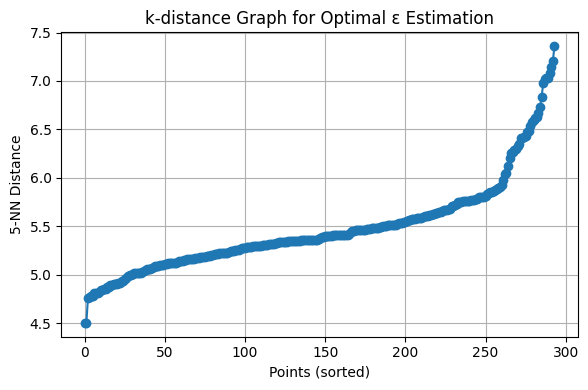

Optimal ε for 4CLI: 6.1


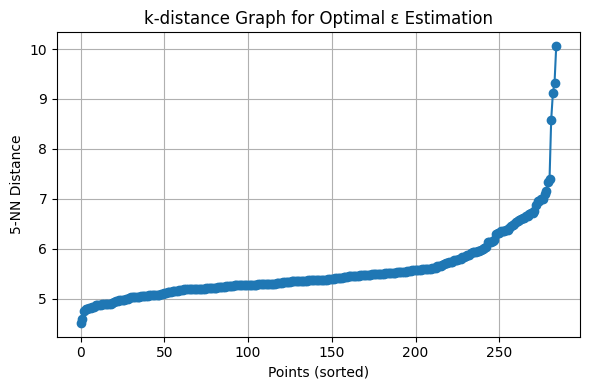

Optimal ε for 2XP2: 6.4


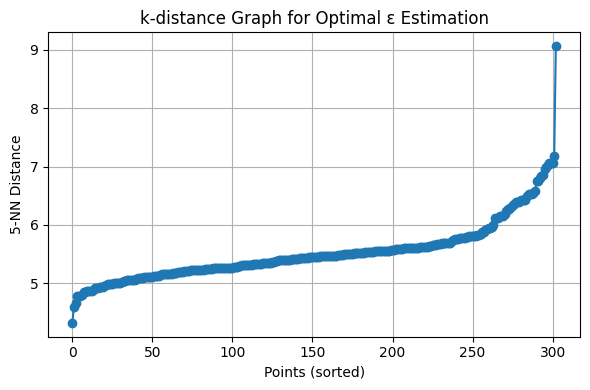

Optimal ε for 4MKC: 6.26


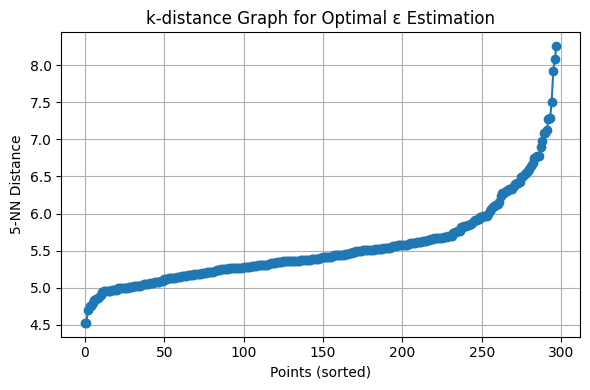

Optimal ε for 5FTO: 6.33


In [18]:
import os

pdb_ids = ["4CLI", "2XP2", "4MKC", "5FTO"]
ca_dir = "ca_coords"

epsilons = {}

for pdb_id in pdb_ids:
    ca_path = os.path.join(ca_dir, f"ca_coords_{pdb_id}.npy")
    ca_coords = np.load(ca_path)

    eps = find_optimal_epsilon(ca_coords, k=5, plot=True)  # Set plot=False if running in batch
    epsilons[pdb_id] = eps
    print(f"Optimal ε for {pdb_id}: {eps}")


In [19]:
import numpy as np
from sklearn.cluster import DBSCAN
from Bio.PDB import PDBParser
from scipy.spatial.distance import cdist

def get_ligand_centroid(pdb_path: str) -> np.ndarray:
    """Computes the centroid of the ligand from a PDB file."""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("ligand", pdb_path)
    coords = np.array([atom.coord for atom in structure.get_atoms()])
    return coords.mean(axis=0)

def detect_pockets_and_match_ligand(pdb_id: str, epsilon: float) -> dict:
    """Detects pockets using DBSCAN and returns the closest pocket to the ligand."""
    ca_coords = np.load(f"ca_coords/ca_coords_{pdb_id}.npy")
    
    # Run DBSCAN
    clustering = DBSCAN(eps=epsilon, min_samples=3).fit(ca_coords)
    labels = clustering.labels_
    
    # Group points into clusters
    clusters = {label: ca_coords[labels == label] for label in set(labels) if label != -1}
    centroids = {label: points.mean(axis=0) for label, points in clusters.items()}

    # Compute ligand centroid
    ligand_resname = {"4CLI": "5p8", "2XP2": "vgh", "4MKC": "4mk", "5FTO": "ymx"}[pdb_id]
    ligand_path = f"ligands/{ligand_resname}.pdb"
    ligand_centroid = get_ligand_centroid(ligand_path)

    # Find the closest cluster centroid
    cluster_ids = list(centroids.keys())
    centroid_coords = np.array([centroids[i] for i in cluster_ids])
    distances = cdist([ligand_centroid], centroid_coords)[0]

    # Find the index of the closest cluster
    closest_index = np.argmin(distances)
    closest_cluster_id = cluster_ids[closest_index]
    closest_distance = distances[closest_index]

    return {
        "pdb_id": pdb_id,
        "ligand_centroid": ligand_centroid,
        "closest_cluster_id": closest_cluster_id,
        "pocket_centroid": centroids[closest_cluster_id],
        "distance": round(float(closest_distance), 2),
        "epsilon": epsilon
    }


In [20]:
# Assuming you've already computed or hardcoded optimal epsilons:
epsilons = {
    "4CLI": 6.1,
    "2XP2": 6.4,
    "4MKC": 6.26,
    "5FTO": 6.33
}

# Run pocket detection and ligand matching for each structure
results = []

for pdb_id in epsilons:
    result = detect_pockets_and_match_ligand(pdb_id, epsilons[pdb_id])
    results.append(result)

# Print summary
for res in results:
    print(f"\nPDB: {res['pdb_id']}")
    print(f"  Ligand Centroid:     {res['ligand_centroid']}")
    print(f"  Closest Pocket ID:   {res['closest_cluster_id']}")
    print(f"  Pocket Centroid:     {res['pocket_centroid']}")
    print(f"  Distance to Pocket:  {res['distance']} Å")
    print(f"  Used ε:              {res['epsilon']}")



PDB: 4CLI
  Ligand Centroid:     [30.7953   46.206524  8.347501]
  Closest Pocket ID:   0
  Pocket Centroid:     [38.01361  47.134827 16.684015]
  Distance to Pocket:  11.07 Å
  Used ε:              6.1

PDB: 2XP2
  Ligand Centroid:     [29.923197 47.06614   8.538533]
  Closest Pocket ID:   0
  Pocket Centroid:     [37.760036 46.965137 17.038681]
  Distance to Pocket:  11.56 Å
  Used ε:              6.4

PDB: 4MKC
  Ligand Centroid:     [-21.253       9.839921   -7.6682625]
  Closest Pocket ID:   0
  Pocket Centroid:     [-13.680405  10.233647 -16.70202 ]
  Distance to Pocket:  11.79 Å
  Used ε:              6.26

PDB: 5FTO
  Ligand Centroid:     [ 4.438781  19.534193   7.5666833]
  Closest Pocket ID:   0
  Pocket Centroid:     [11.791717 19.052643 16.471788]
  Distance to Pocket:  11.56 Å
  Used ε:              6.33


In [21]:
import os
import numpy as np
import py3Dmol

# Set box size (adjustable)
box_size = 20

# Ligand centroids (used as grid centers)
centroids = {
    "4CLI": np.array([30.7953,   46.206524,  8.347501]),
    "2XP2": np.array([29.923197, 47.06614,   8.538533]),
    "4MKC": np.array([-21.253,    9.839921, -7.6682625]),
    "5FTO": np.array([ 4.438781, 19.534193,  7.5666833])
}

# Location of downloaded PDB files
protein_dir = "protein_structures"

# Output directory for HTML snapshots (optional)
os.makedirs("gridbox_html", exist_ok=True)

# Loop through each PDB ID
for pdb_id, center in centroids.items():
    pdb_path = os.path.join(protein_dir, f"{pdb_id}.pdb")
    
    # Read PDB content
    with open(pdb_path, 'r') as file:
        pdb_data = file.read()
    
    # Initialize viewer
    view = py3Dmol.view(width=800, height=600)
    view.addModel(pdb_data, "pdb")
    view.setStyle({"cartoon": {"color": "spectrum"}})
    
    # Draw grid box as transparent red wireframe
    x, y, z = center
    view.addBox({
        "center": {"x": float(x), "y": float(y), "z": float(z)},
        "dimensions": {"w": box_size, "h": box_size, "d": box_size},
        "color": "red",
        "opacity": 0.3,
        "wireframe": True
    })
    
    # Zoom and show
    view.zoomTo()
    
    # Export HTML snapshot
    html_file = os.path.join("gridbox_html", f"{pdb_id}_gridbox.html")
    view.save_html(html_file)
    print(f"Saved {pdb_id} gridbox visualization to {html_file}")


Saved 4CLI gridbox visualization to gridbox_html/4CLI_gridbox.html
Saved 2XP2 gridbox visualization to gridbox_html/2XP2_gridbox.html
Saved 4MKC gridbox visualization to gridbox_html/4MKC_gridbox.html
Saved 5FTO gridbox visualization to gridbox_html/5FTO_gridbox.html


In [22]:
import py3Dmol

def visualize_protein_with_ligand(pdb_file: str, ligand_resname: str = None, pocket_centroid: list = None):
    """Visualizes protein structure with optional bound ligand and predicted pocket location."""

    # Load structure
    with open(pdb_file, "r") as f:
        pdb_data = f.read()

    # Initialize viewer
    view = py3Dmol.view(width=800, height=600)
    view.addModel(pdb_data, "pdb")
    view.setStyle({'cartoon': {'color': 'spectrum'}})

    # Add ligand highlight (optional)
    if ligand_resname:
        view.addStyle({'resn': ligand_resname}, {'stick': {}})

    # Add sphere for pocket centroid
    if pocket_centroid:
        x, y, z = map(float, pocket_centroid)
        view.addSphere({
            'center': {'x': x, 'y': y, 'z': z},
            'radius': 3.0,
            'color': 'red',
            'opacity': 0.7
        })

    view.zoomTo()
    return view.show()


In [23]:
visualize_protein_with_ligand("protein_structures/2XP2.pdb", ligand_resname="VGH", pocket_centroid=[29.923197, 47.06614,  8.538533])


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [24]:
import MDAnalysis as mda
import py3Dmol
import numpy as np
import os

# Define PDB structures and ligands
structures = {
    "4CLI": "5P8",
    "2XP2": "VGH",
    "4MKC": "4MK",
    "5FTO": "YMX"
}

protein_dir = "protein_structures"
output_dir = "annotated_views"
os.makedirs(output_dir, exist_ok=True)

for pdb_id, ligand_resname in structures.items():
    pdb_path = os.path.join(protein_dir, f"{pdb_id}.pdb")
    u = mda.Universe(pdb_path)

    protein = u.select_atoms("protein")
    ligand = u.select_atoms(f"resname {ligand_resname}")

    if len(ligand) == 0:
        print(f" Skipping {pdb_id} - ligand {ligand_resname} not found.")
        continue

    centroid = ligand.center_of_mass()

    # Load 3Dmol view
    with open(pdb_path, "r") as f:
        pdb_data = f.read()

    view = py3Dmol.view(width=800, height=600)
    view.addModel(pdb_data, "pdb")

    # Apply styles *after* model is fully added
    view.setStyle({}, {"cartoon": {"color": "white"}})                      # Protein as white cartoon
    view.addSurface(py3Dmol.VDW, {"opacity": 0.85, "color": "white"})      # White surface

    view.addStyle({"resn": ligand_resname}, {"stick": {"colorscheme": "element"}})  # Ligand ball+stick

    # Add red sphere at ligand centroid
    view.addSphere({
        "center": {
            "x": float(centroid[0]),
            "y": float(centroid[1]),
            "z": float(centroid[2])
        },
        "radius": 2.5,
        "color": "red",
        "opacity": 0.9
    })

    view.zoomTo()
    output_path = os.path.join(output_dir, f"{pdb_id}_{ligand_resname}.html")
    view.write_html(output_path)
    print(f"Saved: {output_path}")


Saved: annotated_views/4CLI_5P8.html
Saved: annotated_views/2XP2_VGH.html
Saved: annotated_views/4MKC_4MK.html
Saved: annotated_views/5FTO_YMX.html


In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_ligand_vs_pocket_centroids(centroids: dict):
    """
    Plots ligand and pocket centroids with lines between them in 3D.

    Args:
        centroids (dict): Dictionary like {
            '4CLI': {'ligand': [x1, y1, z1], 'pocket': [x2, y2, z2]},
            ...
        }
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i, (pdb, data) in enumerate(centroids.items()):
        ax.scatter(*data['ligand'], color='blue')
        ax.scatter(*data['pocket'], color='red')
        ax.plot([data['ligand'][0], data['pocket'][0]],
                [data['ligand'][1], data['pocket'][1]],
                [data['ligand'][2], data['pocket'][2]],
                color='gray', linestyle='--')
        ax.text(*data['ligand'], f"{pdb} L", color='blue')
        ax.text(*data['pocket'], f"{pdb} P", color='red')

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.title("Ligand vs Predicted Pocket Centroids")

    # Add clean legend once
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Ligand Centroid', markerfacecolor='blue', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Pocket Centroid', markerfacecolor='red', markersize=8),
        Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Distance Line')
    ]
    ax.legend(handles=legend_elements)
    plt.show()


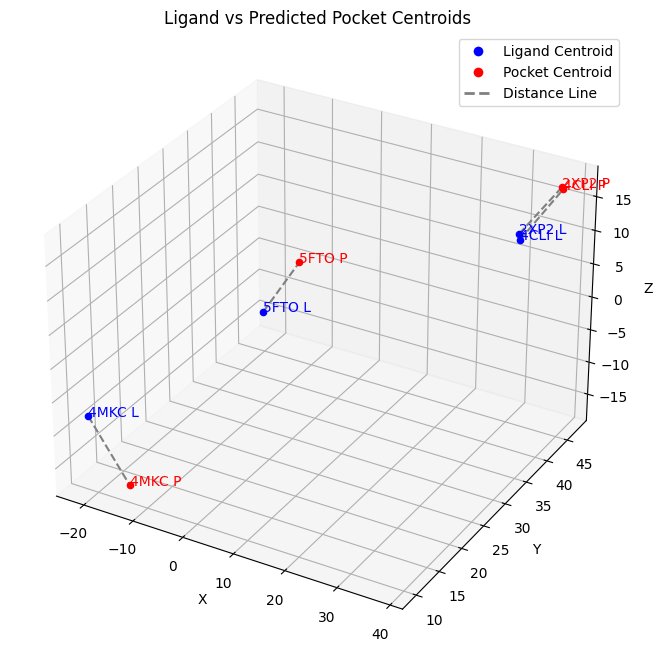

In [26]:
centroids = {
    "4CLI": {"ligand": [30.8, 46.2, 8.3], "pocket": [38.0, 47.1, 16.7]},
    "2XP2": {"ligand": [29.9, 47.1, 8.5], "pocket": [37.8, 47.0, 17.0]},
    "4MKC": {"ligand": [-21.3, 9.8, -7.7], "pocket": [-13.7, 10.2, -16.7]},
    "5FTO": {"ligand": [4.4, 19.5, 7.6], "pocket": [11.8, 19.1, 16.5]},
}

plot_ligand_vs_pocket_centroids(centroids)


In [27]:
from rdkit import Chem
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
import os

# Load ligand (e.g., crizotinib)
ligand_path = "ligands/crizotinib.sdf"
mol = Chem.MolFromMolFile(ligand_path)

# Load feature definitions
fdef_name = os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef')
factory = ChemicalFeatures.BuildFeatureFactory(fdef_name)

# Detect pharmacophoric features
features = factory.GetFeaturesForMol(mol)

# Display all pharmacophoric features
for feat in features:
    print(f"Type: {feat.GetType():<20} Position: {feat.GetPos()}")


Type: SingleAtomDonor      Position: <rdkit.Geometry.rdGeometry.Point3D object at 0x7fa1288ff540>
Type: SingleAtomDonor      Position: <rdkit.Geometry.rdGeometry.Point3D object at 0x7fa1288ff540>
Type: SingleAtomAcceptor   Position: <rdkit.Geometry.rdGeometry.Point3D object at 0x7fa1288ff540>
Type: SingleAtomAcceptor   Position: <rdkit.Geometry.rdGeometry.Point3D object at 0x7fa1288ff540>
Type: SingleAtomAcceptor   Position: <rdkit.Geometry.rdGeometry.Point3D object at 0x7fa1288ff540>
Type: SingleAtomAcceptor   Position: <rdkit.Geometry.rdGeometry.Point3D object at 0x7fa0cec70340>
Type: BasicGroup           Position: <rdkit.Geometry.rdGeometry.Point3D object at 0x7fa0cec70340>
Type: Arom5                Position: <rdkit.Geometry.rdGeometry.Point3D object at 0x7fa0cec70340>
Type: Arom6                Position: <rdkit.Geometry.rdGeometry.Point3D object at 0x7fa0cec70340>
Type: Arom6                Position: <rdkit.Geometry.rdGeometry.Point3D object at 0x7fa1288ff540>
Type: ThreeWayAttach

In [28]:
from rdkit.Geometry import Point3D

# Format readable table
print(f"{'Type':<20} {'X':>8} {'Y':>8} {'Z':>8}")
print("-" * 45)
for feat in features:
    pos: Point3D = feat.GetPos()
    print(f"{feat.GetType():<20} {pos.x:8.2f} {pos.y:8.2f} {pos.z:8.2f}")


Type                        X        Y        Z
---------------------------------------------
SingleAtomDonor          2.59    -4.94     0.00
SingleAtomDonor          8.35     1.00     0.00
SingleAtomAcceptor       7.49     5.50     0.00
SingleAtomAcceptor       6.62     2.00     0.00
SingleAtomAcceptor       3.31    -1.33     0.00
SingleAtomAcceptor       7.49    -0.50     0.00
BasicGroup               2.59    -4.94     0.00
Arom5                    4.15    -1.42     0.00
Arom6                    6.62     0.00     0.00
Arom6                    5.76     4.50     0.00
ThreeWayAttach           4.89    -1.00     0.00
ThreeWayAttach           5.76    -0.50     0.00
ThreeWayAttach           5.76     3.50     0.00
ThreeWayAttach           6.62     4.00     0.00
ThreeWayAttach           4.89     4.00     0.00
RH6_6                    5.76     4.50     0.00


In [29]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
import py3Dmol
import os

def visualize_pharmacophore_3d(ligand_path: str, feature_factory_path: str = None):
    """
    Visualizes pharmacophore features on a 3D structure of a ligand using py3Dmol.

    Args:
        ligand_path (str): Path to the ligand SDF/MOL file.
        feature_factory_path (str, optional): Path to feature definition file. Defaults to RDKit base.
    """

    # Load ligand
    mol = Chem.MolFromMolFile(ligand_path, removeHs=False)
    if mol is None:
        raise ValueError(f"Failed to load molecule from: {ligand_path}")

    # Generate conformer if not present
    if mol.GetNumConformers() == 0:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.UFFOptimizeMolecule(mol)

    # Load feature factory
    if feature_factory_path is None:
        fdef = os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef')
    else:
        fdef = feature_factory_path
    factory = ChemicalFeatures.BuildFeatureFactory(fdef)

    # Compute pharmacophore features
    features = factory.GetFeaturesForMol(mol)

    # Start visualization
    view = py3Dmol.view(width=600, height=400)
    block = Chem.MolToMolBlock(mol)
    view.addModel(block, 'mol')
    view.setStyle({'stick': {}})

    # Add colored spheres for each pharmacophore feature
    color_map = {
        "SingleAtomDonor": "blue",
        "SingleAtomAcceptor": "red",
        "Arom6": "purple",
        "Arom5": "magenta",
        "BasicGroup": "green",
        "Hydrophobe": "orange",
        "ThreeWayAttach": "gray",
        "RH6_6": "yellow"
    }

    for feat in features:
        pos = feat.GetPos()
        ftype = feat.GetType()
        color = color_map.get(ftype, 'white')
        view.addSphere({
            'center': {'x': pos.x, 'y': pos.y, 'z': pos.z},
            'radius': 0.5,
            'color': color,
            'opacity': 0.8
        })

    view.zoomTo()
    return view.show()


In [30]:
visualize_pharmacophore_3d("ligands/crizotinib.sdf")


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [31]:
def compute_pocket_properties(pocket_coords: np.ndarray, label: str):
    """
    Computes and returns pocket properties from coordinates.

    Args:
        pocket_coords (np.ndarray): N x 3 array of XYZ positions.
        label (str): Identifier for the structure (e.g., "5FTO").

    Returns:
        dict: Properties of the binding pocket.
    """
    centroid = np.mean(pocket_coords, axis=0)
    min_coords = np.min(pocket_coords, axis=0)
    max_coords = np.max(pocket_coords, axis=0)
    extent = max_coords - min_coords
    volume = np.prod(extent)

    return {
        "PDB": label,
        "Centroid X": round(centroid[0], 2),
        "Centroid Y": round(centroid[1], 2),
        "Centroid Z": round(centroid[2], 2),
        "Extent X": round(extent[0], 2),
        "Extent Y": round(extent[1], 2),
        "Extent Z": round(extent[2], 2),
        "Volume (Å³)": round(volume, 2)
    }


In [32]:
import pandas as pd

all_pocket_data = []

# Example: Add manually for 5FTO
coords_5fto = np.array([
    [11.5, 18.7, 16.3],
    [12.1, 19.2, 16.6]
])
all_pocket_data.append(compute_pocket_properties(coords_5fto, "5FTO"))

# Add other PDBs here similarly...

# Display as DataFrame
df = pd.DataFrame(all_pocket_data)
print(df.to_markdown(index=False))  # or df.to_csv() for slide export


| PDB   |   Centroid X |   Centroid Y |   Centroid Z |   Extent X |   Extent Y |   Extent Z |   Volume (Å³) |
|:------|-------------:|-------------:|-------------:|-----------:|-----------:|-----------:|--------------:|
| 5FTO  |         11.8 |        18.95 |        16.45 |        0.6 |        0.5 |        0.3 |          0.09 |


In [33]:
import MDAnalysis as mda
import numpy as np

# Example: Load one PDB and pocket coordinates (from DBSCAN or similar)
u = mda.Universe("protein_structures/5FTO.pdb")

# Assuming you have a numpy array of pocket atom coordinates
pocket_coords = np.array([[11.8, 19.0, 16.4], [12.1, 19.2, 16.6], [11.5, 18.7, 16.3]])

# Compute pocket center
centroid = np.mean(pocket_coords, axis=0)
min_coords = np.min(pocket_coords, axis=0)
max_coords = np.max(pocket_coords, axis=0)
volume = np.prod(max_coords - min_coords)
extent = max_coords - min_coords

# Report
print("Pocket Properties:")
print(f"  Centroid: {centroid}")
print(f"  Bounding Box Min: {min_coords}")
print(f"  Bounding Box Max: {max_coords}")
print(f"  Volume Estimate: {volume:.2f} Å³")
print(f"  Pocket Extent: {extent}")


Pocket Properties:
  Centroid: [11.8        18.96666667 16.43333333]
  Bounding Box Min: [11.5 18.7 16.3]
  Bounding Box Max: [12.1 19.2 16.6]
  Volume Estimate: 0.09 Å³
  Pocket Extent: [0.6 0.5 0.3]


### Step 5: Preparing Ligand Structures for Docking

In this step, we will prepare the ligand structures by converting each optimized ligand from PDB format to PDBQT format using **Meeko**. The PDBQT format is required for AutoDock Vina as it includes additional information about atomic charges and flexibility.

1. **Input Ligand Files**: We start with optimized ligand files in PDB format.
2. **Convert to PDBQT**: Using Meeko, each ligand will be converted to the PDBQT format, adding the necessary docking information.
3. **Save in PDBQT Directory**: The converted files will be saved in the `pdbqt/ligands` directory, organized for docking.

In [34]:
import os
import subprocess
from rdkit import Chem
from rdkit.Chem import AllChem

# === Step 1: Define ligand names and paths ===
ligand_names = [
    "crizotinib", "ceritinib", "alectinib", "brigatinib", "ensartinib", "lorlatinib", "ymx"
]

ligand_dir = "ligands"
pdbqt_dir = "pdbqt"
os.makedirs(ligand_dir, exist_ok=True)
os.makedirs(pdbqt_dir, exist_ok=True)

# === Step 2: Convert .pdb to .sdf if needed ===
for name in ligand_names:
    pdb_path = f"{ligand_dir}/{name}.pdb"
    sdf_path = f"{ligand_dir}/{name}.sdf"

    if not os.path.exists(sdf_path) and os.path.exists(pdb_path):
        try:
            subprocess.run(["obabel", pdb_path, "-O", sdf_path], check=True)
            print(f"Converted {pdb_path} to {sdf_path}")
        except subprocess.CalledProcessError as e:
            print(f"Error converting {name} from PDB to SDF: {e}")
    elif os.path.exists(sdf_path):
        print(f"{sdf_path} already exists. Skipping .pdb to .sdf conversion.")
    else:
        print(f"Missing both .sdf and .pdb for {name}, skipping.")

# === Step 3: Ensure SDFs are 3D and have explicit Hs ===
for name in ligand_names:
    sdf_path = f"{ligand_dir}/{name}.sdf"
    if os.path.exists(sdf_path):
        try:
            mol = Chem.SDMolSupplier(sdf_path, removeHs=False)[0]
            if mol is None:
                print(f"Failed to load molecule from {sdf_path}")
                continue

            mol = Chem.AddHs(mol)
            AllChem.EmbedMolecule(mol, randomSeed=0xf00d)
            AllChem.UFFOptimizeMolecule(mol)

            # Overwrite SDF with 3D-processed version
            writer = Chem.SDWriter(sdf_path)
            writer.write(mol)
            writer.close()
            print(f"Processed 3D molecule saved to {sdf_path}")
        except Exception as e:
            print(f"Error processing {name} for 3D: {e}")
    else:
        print(f"SDF file missing for {name}. Skipping.")

# === Step 4: Convert all SDFs to PDBQT using Meeko ===
def convert_sdf_to_pdbqt(input_sdf: str, output_pdbqt: str):
    try:
        subprocess.run(
            ["mk_prepare_ligand.py", "-i", input_sdf, "-o", output_pdbqt],
            check=True
        )
        print(f"Converted {input_sdf} to {output_pdbqt}")
    except subprocess.CalledProcessError as e:
        print(f"Failed to convert {input_sdf} to PDBQT: {e}")

for name in ligand_names:
    sdf_path = f"{ligand_dir}/{name}.sdf"
    pdbqt_path = os.path.join(pdbqt_dir, f"{name}.pdbqt")

    if not os.path.exists(pdbqt_path) and os.path.exists(sdf_path):
        print(f"Converting {name} to PDBQT...")
        convert_sdf_to_pdbqt(sdf_path, pdbqt_path)
    elif os.path.exists(pdbqt_path):
        print(f"{pdbqt_path} already exists. Skipping PDBQT conversion.")
    else:
        print(f"Missing input SDF for {name}, skipping PDBQT step.")


ligands/crizotinib.sdf already exists. Skipping .pdb to .sdf conversion.
ligands/ceritinib.sdf already exists. Skipping .pdb to .sdf conversion.
ligands/alectinib.sdf already exists. Skipping .pdb to .sdf conversion.
ligands/brigatinib.sdf already exists. Skipping .pdb to .sdf conversion.
ligands/ensartinib.sdf already exists. Skipping .pdb to .sdf conversion.
ligands/lorlatinib.sdf already exists. Skipping .pdb to .sdf conversion.
ligands/ymx.sdf already exists. Skipping .pdb to .sdf conversion.
Processed 3D molecule saved to ligands/crizotinib.sdf
Processed 3D molecule saved to ligands/ceritinib.sdf
Processed 3D molecule saved to ligands/alectinib.sdf
Processed 3D molecule saved to ligands/brigatinib.sdf
Processed 3D molecule saved to ligands/ensartinib.sdf
Processed 3D molecule saved to ligands/lorlatinib.sdf
Processed 3D molecule saved to ligands/ymx.sdf
pdbqt/crizotinib.pdbqt already exists. Skipping PDBQT conversion.
pdbqt/ceritinib.pdbqt already exists. Skipping PDBQT conversion

# Docking

In [35]:
import os
import subprocess

# === Define ligand inputs ===
ligands = {
    "lorlatinib": "Lorlatinib",
    "crizotinib": "Crizotinib",
    "ceritinib": "Ceritinib",
    "alectinib": "Alectinib",
    "brigatinib": "Brigatinib",
    "ensartinib": "Ensartinib"
}

# === Define grid parameters (from Pocket 0 in 4CLI) ===
center = [38.01, 47.13, 16.68]
size = [20, 20, 20]

# === Define file paths ===
protein_pdbqt = "pdbqt/protein_4CLI_cleaned.pdbqt"  # <-- corrected
ligand_dir = "pdbqt"
output_dir = "docked_common_protein"
os.makedirs(output_dir, exist_ok=True)

# === Vina parameters ===
exhaustiveness = 8

# === Dock each ligand ===
for ligand_id, drug_name in ligands.items():
    ligand_pdbqt = os.path.join(ligand_dir, f"{ligand_id}.pdbqt")
    output_pdbqt = os.path.join(output_dir, f"{ligand_id}_in_4CLI_docked.pdbqt")
    log_file = os.path.join(output_dir, f"{ligand_id}_in_4CLI_log.txt")

    print(f"Docking {drug_name} ({ligand_id.upper()}) into 4CLI...")

    cmd = [
        "vina",
        "--receptor", protein_pdbqt,
        "--ligand", ligand_pdbqt,
        "--center_x", str(center[0]),
        "--center_y", str(center[1]),
        "--center_z", str(center[2]),
        "--size_x", str(size[0]),
        "--size_y", str(size[1]),
        "--size_z", str(size[2]),
        "--out", output_pdbqt,
        "--log", log_file,
        "--exhaustiveness", str(exhaustiveness)
    ]

    try:
        subprocess.run(cmd, check=True)
        print(f" Docked {drug_name} saved: {output_pdbqt}")
    except subprocess.CalledProcessError as e:
        print(f"Docking failed for {drug_name}: {e}")


Docking Lorlatinib (LORLATINIB) into 4CLI...
#################################################################
# If you used AutoDock Vina in your work, please cite:          #
#                                                               #
# O. Trott, A. J. Olson,                                        #
# AutoDock Vina: improving the speed and accuracy of docking    #
# with a new scoring function, efficient optimization and       #
# multithreading, Journal of Computational Chemistry 31 (2010)  #
# 455-461                                                       #
#                                                               #
# DOI 10.1002/jcc.21334                                         #
#                                                               #
# Please see http://vina.scripps.edu for more information.      #
#################################################################

Detected 12 CPUs
Reading input ... done.
Setting up the scoring function ... done.
Analyzing the